In [193]:
import pandas as pd

### The Class

In [1]:
%%writefile ../graph.py
# Partial Ranker
#
# Copyright (C) 2019-2024, Aravind Sankaran
# IRTG-2379: Modern Inverse Problems, RWTH Aachen University, Germany
# HPAC, Umeå University, Sweden
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.
#
# Contributors:
# - Aravind Sankaran

import pandas as pd
from typing import List

class Graph:
    """Class to represent the dependencies of the objects as a transitively reduced directed acyclic graph.
    
    Inputs:
        **deps (dict[str, list[str]])**: Dictionary with nodes as keys and a list of nodes that it depends on as values.
            
            - e.g.; if dependency is based on a better-than relation, then in deps that look like ``{'obj1': ['obj2', 'obj3], 'obj2': ['obj4'], ...}``, ``obj2`` and ``obj3`` are better than ``obj1``, ``obj4`` is better than ``obj2``, etc.

        **depths (dict[int,List[str]])**: A dictionary consisting of the list of objects at each rank.
            
            - e.g.; in  ``{0: ['obj1'], 1: ['obj2', 'obj3'], ...}``, ``obj1`` is at rank 0, ``obj2`` and ``obj3`` are at rank 1, etc.
            
    **Attributes and Methods**:
    
    Attributes:
        in_nodes (dict[str, list[str]]): Dictionary with nodes as keys and a list of nodes that has incoming edges to the node indicated in the key.
        out_nodes (dict[str, list[str]]): Dictionary with nodes as keys and a list of nodes that has outgoing edges from the node indicated in the key.
    
    """
    def __init__(self,dependencies, depths):
        self.deps = dependencies
        self.depths = depths
        
        self.in_nodes = {}
        self.out_nodes = {}
        self._find_transitive_edges()
    
    def _find_transitive_edges(self):
        for d in range(len(self.depths)-1):
            for node1 in self.depths[d]:
                for node2 in self.depths[d+1]:
                    if node1 in self.deps[node2]:
                        self.in_nodes[node2] = self.in_nodes.get(node2,[]) + [node1]
                        self.out_nodes[node1] = self.out_nodes.get(node1,[]) + [node2]
            
                    
    def visualize(self,highlight_nodes=[]):
        """Visualize the dependencies and ranks of the objects as a transitively reduced directed acyclic graph.

        Args:
            highlight_nodes (list, optional): The nodes in this list are highlighted in the visualization. Defaults to [].

        Returns:
            graphviz.Digraph: A graphviz object.
        """
        import graphviz
        
        g = graphviz.Digraph()
        for node in self.deps.keys():
            color='#f0efed'
            if node in highlight_nodes:
                color = '#f2ecc7'
            g.node(node,style='filled',color=color)
            
        for node1,v in self.out_nodes.items():
            for node2 in v:
                if node1 in highlight_nodes:
                    g.edge(node1, node2, style='filled', color='blue')
                else:
                    g.edge(node1, node2)
                
        return g
    
    
    def get_separable_arrangement(self) -> List:
        """
        Returns:
            List[str]: Arrangement of the objects according to Methodology 2 (Step 1 to 3) in the paper. 
        """
        h0_ = [] # The list h0_ is same as T in the paper. 
        for rank in range(len(self.depths)):
            nodes = []
            num_in_nodes = []
            num_out_nodes = []
            for node in self.depths[rank]:
                nodes.append(node)
                if node in self.in_nodes:
                    num_in_nodes.append(len(self.in_nodes[node]))
                else:
                    num_in_nodes.append(0)
                
                if node in self.out_nodes:
                    num_out_nodes.append(len(self.out_nodes[node]))
                else:
                    num_out_nodes.append(0)
            df = pd.DataFrame(list(zip(nodes, num_out_nodes, num_in_nodes)))
            h0_ = h0_ + list(df.sort_values([1,2],ascending=[False,True])[0])
        return h0_
        

Overwriting ../graph.py


### Requirements

In [1]:
import numpy as np
from partial_ranker.measurements_simulator import MeasurementsSimulator
from partial_ranker.measurements_visualizer import MeasurementsVisualizer
from partial_ranker import QuantileComparer
from partial_ranker.partial_ranker_dfg import PartialRankerDFG

1) Sample measurements

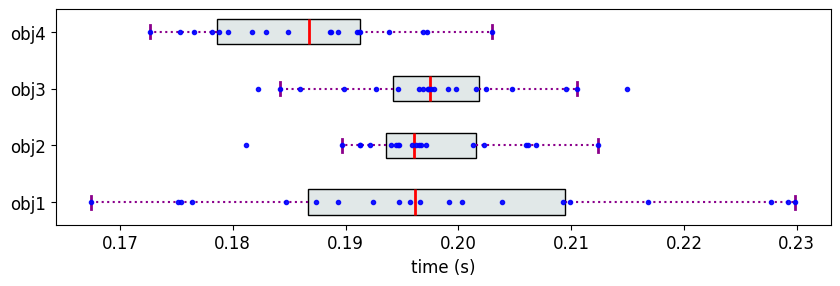

In [2]:
obj_params = {}
obj_params['obj1']  = [0.2,0.02] # [mean, std]
obj_params['obj2']  = [0.2,0.01]
obj_params['obj3']  = [0.2,0.01]
obj_params['obj4']  = [0.19,0.01]
ms = MeasurementsSimulator(obj_params,seed=129)
reps = 20
ms.measure(reps=reps)
measurements = ms.get_measurements()
h0 = list(obj_params.keys())
mv = MeasurementsVisualizer(measurements, h0)
fig = mv.show_measurements_boxplots(scale=0.7)

2) Compare and Compute partial ranks

In [3]:
comparer = QuantileComparer(measurements)
comparer.compute_quantiles(q_max=75, q_min=25,outliers=False)
comparer.compare()
pr_dfg = PartialRankerDFG(comparer)
pr_dfg.compute_ranks()

### Usage

In [6]:
gr = Graph(pr_dfg.dependencies, pr_dfg.get_ranks())

In [7]:
gr.out_nodes

{'obj4': ['obj2', 'obj3']}

In [8]:
gr.in_nodes

{'obj2': ['obj4'], 'obj3': ['obj4']}

In [9]:
gr.depths

{0: ['obj1', 'obj4'], 1: ['obj2', 'obj3']}

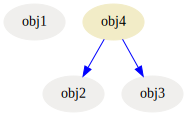

In [10]:
gr.visualize(highlight_nodes=['obj4'])

In [11]:
h0_ = gr.get_separable_arrangement()
h0_

['obj4', 'obj1', 'obj2', 'obj3']

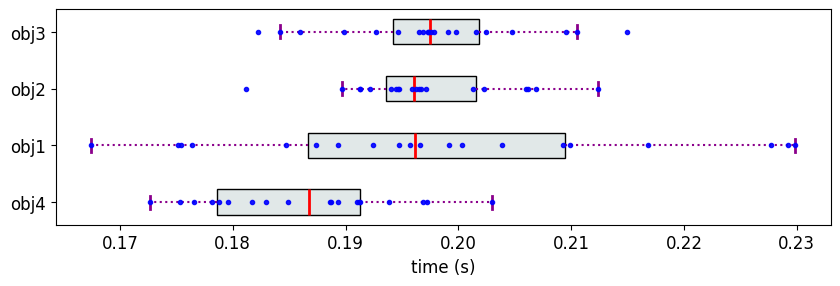

In [12]:
mv = MeasurementsVisualizer(measurements, h0_)
fig = mv.show_measurements_boxplots(scale=0.7)

### Scaling experiment

In [13]:
def create_measurements(n_objs, n_reps, seed=129):
    obj_params = {}
    for i in range(n_objs):
        obj_params[f'obj{i}'] = [np.random.uniform(0,1), np.random.uniform(0,0.1)]
    ms = MeasurementsSimulator(obj_params,seed=seed)
    ms.measure(reps=n_reps)
    return ms.get_measurements()

measurements = create_measurements(50, 5)

cm = QuantileComparer(measurements)
cm.compute_quantiles(75, 25,False)
cm.compare()

pr_dfg = PartialRankerDFG(cm)
pr_dfg.compute_ranks()


In [14]:
gr = Graph(pr_dfg.dependencies, pr_dfg.get_ranks())

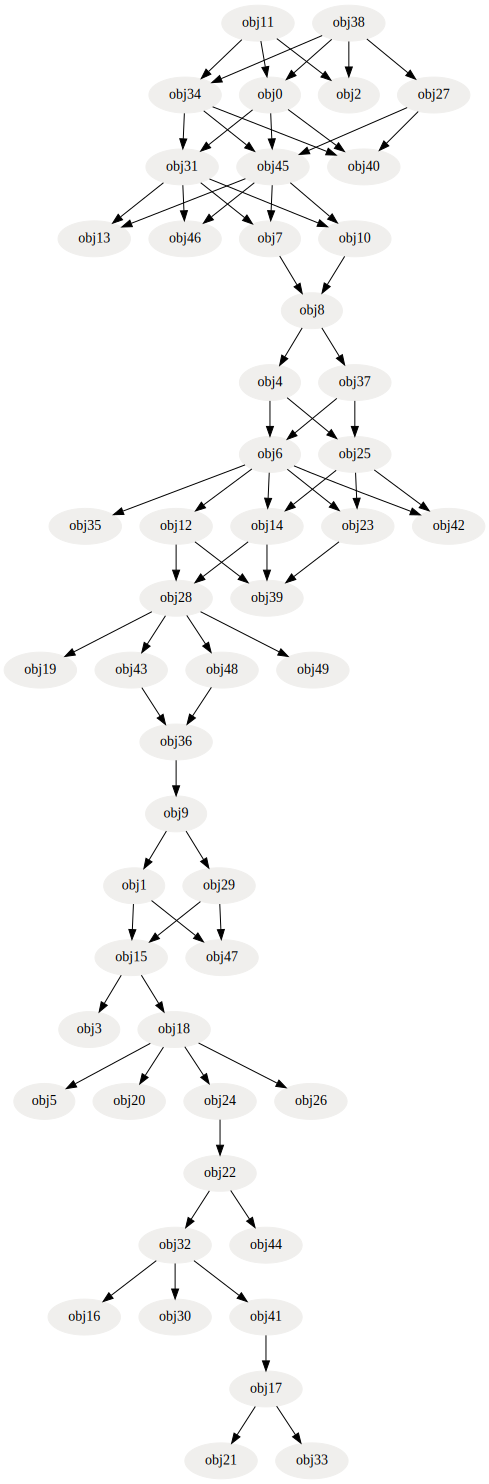

In [15]:
gr.visualize()

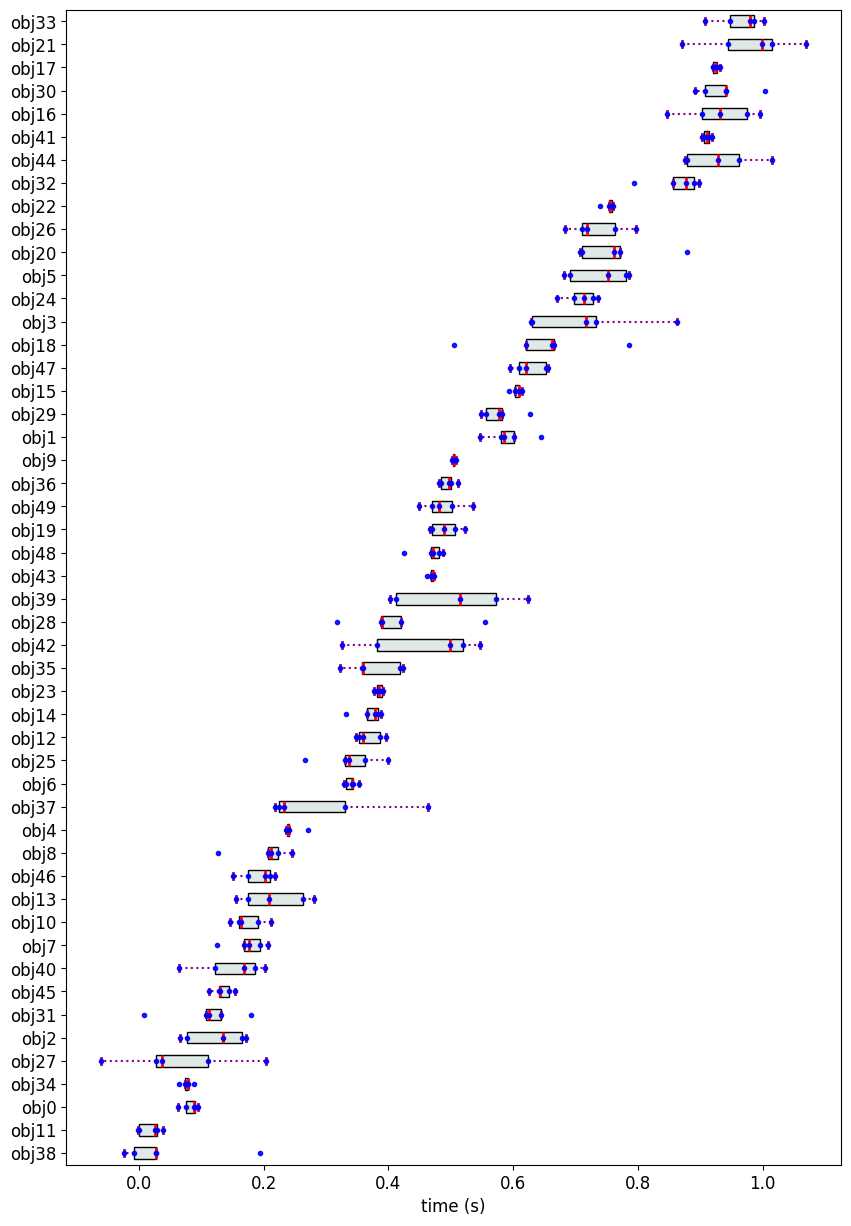

In [16]:
h0_ = gr.get_separable_arrangement()
mv = MeasurementsVisualizer(measurements, h0_)
fig = mv.show_measurements_boxplots(scale=0.3)